In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
col_select = ['device','geoNetwork','totals','trafficSource']

# Read The Training Data

In [3]:
df_raw = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/train.csv',\
                  converters={cols:json.loads for cols in col_select},dtype={'fullVisitorId': 'str'},header=0)

In [4]:
for cols in col_select:
    column_as_df = json_normalize(df_raw[cols])
    column_as_df.columns = [f"{cols}.{subcolumn}" for subcolumn in column_as_df.columns]
    df_raw = df_raw.drop(cols,axis=1)
    df_raw = df_raw.merge(column_as_df,left_index=True,right_index=True)

# Read the Test Data

In [5]:
df_train = df_raw.copy()

In [6]:
df_test_raw = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/test.csv',\
                  converters={cols:json.loads for cols in col_select},dtype={'fullVisitorId': 'str'},header=0)

In [7]:
col_select_test = ['device','geoNetwork','totals','trafficSource']

In [8]:
df_test_raw.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",6167871330617112363,"{'continent': 'Asia', 'subContinent': 'Southea...",6167871330617112363_1508151024,Not Socially Engaged,"{'visits': '1', 'hits': '4', 'pageviews': '4'}","{'campaign': '(not set)', 'source': 'google', ...",1508151024,2,1508151024
1,Organic Search,20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",0643697640977915618,"{'continent': 'Europe', 'subContinent': 'South...",0643697640977915618_1508175522,Not Socially Engaged,"{'visits': '1', 'hits': '5', 'pageviews': '5',...","{'campaign': '(not set)', 'source': 'google', ...",1508175522,1,1508175522
2,Organic Search,20171016,"{'browser': 'Chrome', 'browserVersion': 'not a...",6059383810968229466,"{'continent': 'Europe', 'subContinent': 'Weste...",6059383810968229466_1508143220,Not Socially Engaged,"{'visits': '1', 'hits': '7', 'pageviews': '7',...","{'campaign': '(not set)', 'source': 'google', ...",1508143220,1,1508143220
3,Organic Search,20171016,"{'browser': 'Safari', 'browserVersion': 'not a...",2376720078563423631,"{'continent': 'Americas', 'subContinent': 'Nor...",2376720078563423631_1508193530,Not Socially Engaged,"{'visits': '1', 'hits': '8', 'pageviews': '4',...","{'campaign': '(not set)', 'source': 'google', ...",1508193530,1,1508193530
4,Organic Search,20171016,"{'browser': 'Safari', 'browserVersion': 'not a...",2314544520795440038,"{'continent': 'Americas', 'subContinent': 'Nor...",2314544520795440038_1508217442,Not Socially Engaged,"{'visits': '1', 'hits': '9', 'pageviews': '4',...","{'campaign': '(not set)', 'source': 'google', ...",1508217442,1,1508217442


In [9]:
for cols in col_select:
    column_as_df = json_normalize(df_test_raw[cols])
    column_as_df.columns = [f"{cols}.{subcolumn}" for subcolumn in column_as_df.columns]
    df_test_raw = df_test_raw.drop(cols,axis=1)
    df_test_raw = df_test_raw.merge(column_as_df,left_index=True,right_index=True)

# Concatenate the Training and Test Dat

In [10]:
df_train.columns.difference(df_test_raw.columns)

Index(['totals.transactionRevenue', 'trafficSource.campaignCode'], dtype='object')

In [11]:
df_test_raw.columns.difference(df_train.columns)

Index([], dtype='object')

In [12]:
df3 = pd.concat([df_train.drop(['totals.transactionRevenue', 'trafficSource.campaignCode'],axis=1),df_test_raw],ignore_index=True) 

In [13]:
df_train.shape

(903653, 55)

In [14]:
len_df_train = df_train.shape[0]

# Split Feature and Label Data

In [15]:
train_y = df_train['totals.transactionRevenue'].fillna(0).astype(float).apply(lambda x: np.log1p(x))

# Add Visit Time

In [16]:
df3['diff_visitId_time'] = df3['visitId'] - df3['visitStartTime']
df3['diff_visitId_time'] = (df3['diff_visitId_time'] != 0).astype(int)

# Format the Numerous Variables

In [17]:
list_v = ['totals.hits','totals.pageviews','trafficSource.adwordsClickInfo.page']

In [18]:
for cols in list_v:
    df3[cols]=df3[cols].astype(float)

##  Drop the Constant Columns

In [19]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
#         print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

# Convert the Object Values to Numeric

In [20]:
for cols in df3.columns:
    if df3[cols].dtypes == object or df3[cols].dtypes== bool:
#         df3[cols] = df3[cols].astype('category')
#         df3["new_"+cols] = df3[cols].cat.codes
        df3["new_"+cols] = pd.factorize( df3[cols])[0]
        df3 = df3.drop(cols,axis=1)
        df3 = df3.rename(columns={"new_"+cols:cols})

# Convert Date to Numeric Variables

In [21]:
format_str = '%Y%m%d' 
df3['date'] = df3['date'].apply(lambda x: datetime.strptime(str(x), format_str))


In [22]:
df3['date_dayofweek'] = df3['date'].dt.dayofweek
df3['date_year'] = df3['date'].dt.year

df3['date_hour'] = df3['date'].dt.hour

df3['date_month'] = df3['date'].dt.month
df3['date_day'] = df3['date'].dt.day

df3['date_month'] = df3['date'].apply(lambda x:x.month)
df3['date_quarter_month'] = df3['date'].apply(lambda x:x.day//8)
df3['date_weekday'] = df3['date'].apply(lambda x:x.weekday())


In [23]:
df3 = df3.drop('date',axis=1)

# Visit Time

In [24]:
df3['visitStartTime'] = df3['visitStartTime'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))

# df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'],unit='s')

In [25]:
df3['visitStartTime'] = pd.to_datetime(df3['visitStartTime'])

df3['quarter_month'] = df3['visitStartTime'].apply(lambda x:x.day//8)

# df3.loc[1020:1025,['visitStartTime','quarter_month']]

df3['quarter_month'].value_counts()

df3['day_month'] = df3['visitStartTime'].apply(lambda x:x.day)


# df3['day_month'].value_counts()

df3['WoY'] = df3['visitStartTime'].apply(lambda x: x.isocalendar()[1])

# df3['WoY'].value_counts()

df3['visit_dayofweek'] = df3['visitStartTime'].dt.dayofweek
df3['visit_year'] = df3['visitStartTime'].dt.year

df3['visit_month'] = df3['visitStartTime'].dt.month
df3['visit_day'] = df3['visitStartTime'].dt.day
df3['visit_hour'] = df3['visitStartTime'].dt.hour

df3 = df3.drop('visitStartTime',axis=1)

# Clean the Data Again

##  Drop the Constant Columns

In [26]:
cols_drop = []
for cols in df3.columns:
    if df3[cols].nunique()==1:
#         print(cols)
        cols_drop.append(cols)
        
df3 = df3.drop(cols_drop,axis=1)

date_hour


# Baseline Model

# Split Feature and Label Data

In [27]:
train_x = df3[:len_df_train]


In [28]:
test_x = df3[len_df_train:]

# Training Model

In [29]:

# regr = RandomForestRegressor(max_depth=2, random_state=0,
#                              n_estimators=100)


# def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
#     predictions = model.predict(X_train)
#     mse = mean_squared_error(y_train, predictions)
#     rmse = np.sqrt(mse)
#     return rmse



# import numpy as np

# # calc_train_error(train_x, train_y, model)

In [38]:
param = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         'boosting_type' : 'gbdt', 
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [39]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_x))
predictions = np.zeros(len(test_x))
start = time.time()
features = list(train_x.columns)
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_x.values, train_y.values)):
    trn_data = lgb.Dataset(train_x.iloc[trn_idx].values, label=train_y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train_x.iloc[val_idx].values, label=train_y.iloc[val_idx].values)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_x.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_x.values, num_iteration=clf.best_iteration) / folds.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.75516	valid_1's rmse: 1.77103
[200]	training's rmse: 1.6192	valid_1's rmse: 1.67848
[300]	training's rmse: 1.53811	valid_1's rmse: 1.63823
[400]	training's rmse: 1.48339	valid_1's rmse: 1.62054
[500]	training's rmse: 1.44158	valid_1's rmse: 1.61197
[600]	training's rmse: 1.40637	valid_1's rmse: 1.60759
[700]	training's rmse: 1.37613	valid_1's rmse: 1.6055
[800]	training's rmse: 1.34919	valid_1's rmse: 1.60398
[900]	training's rmse: 1.32526	valid_1's rmse: 1.60349
[1000]	training's rmse: 1.30308	valid_1's rmse: 1.60346
[1100]	training's rmse: 1.28306	valid_1's rmse: 1.6035
Early stopping, best iteration is:
[1035]	training's rmse: 1.29598	valid_1's rmse: 1.60334
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.75618	valid_1's rmse: 1.76368
[200]	training's rmse: 1.61943	valid_1's rmse: 1.67473
[300]	training's rmse: 1.53824	valid_1's rmse: 1.63782
[400]	training

In [40]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, train_y)**0.5))

CV score: 1.61400 


/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


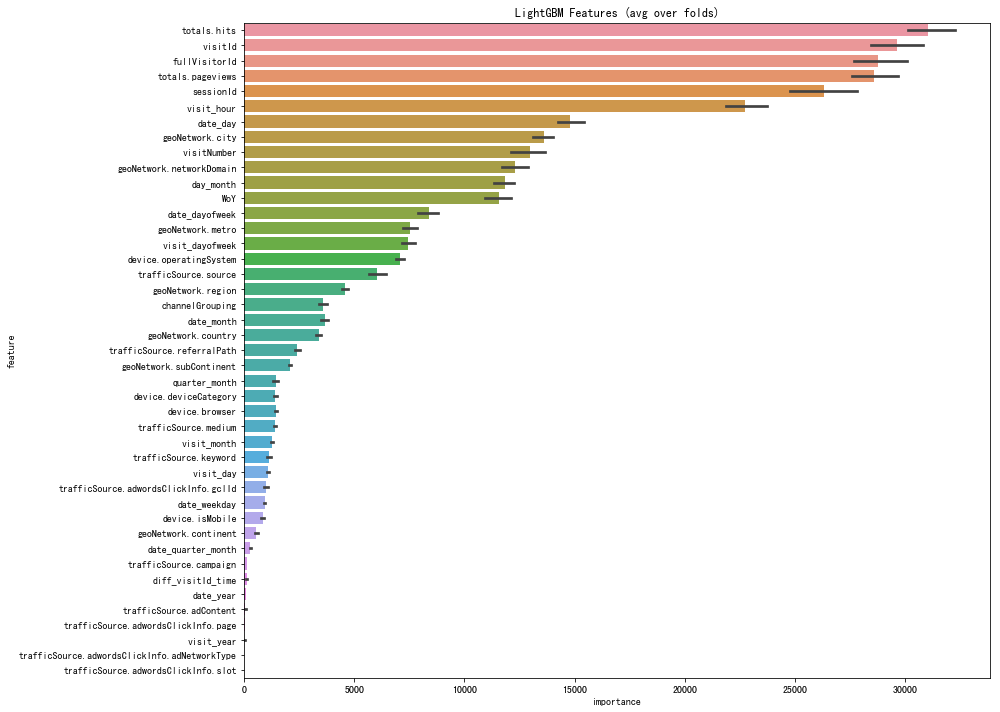

In [41]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:1000].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [42]:
submission = df_test_raw[['fullVisitorId']].copy()

submission.loc[:, 'PredictedLogRevenue'] = predictions
submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test["PredictedLogRevenue"] =  grouped_test["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
grouped_test['fullVisitorId']=grouped_test['fullVisitorId'].astype('str')
grouped_test.to_csv('mySubmit1017.csv',index=False)